In [1]:
!wget https://raw.githubusercontent.com/mam863/Hauspreise/main/wohnungen_mit_bezirk_excel.csv


--2025-06-16 07:26:40--  https://raw.githubusercontent.com/mam863/Hauspreise/main/wohnungen_mit_bezirk_excel.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 501841 (490K) [text/plain]
Saving to: ‘wohnungen_mit_bezirk_excel.csv’

wohnungen_mit_bezir 100%[===================>] 490.08K  2.21MB/s    in 0.2s    

2025-06-16 07:26:41 (2.21 MB/s) - ‘wohnungen_mit_bezirk_excel.csv’ saved [501841/501841]



In [2]:
"""
Berlin Housing Price Prediction Model
Following CRISP-DM methodology

This script implements a machine learning model to predict housing prices in Berlin
based on various features like area, rooms, location, etc.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as XGBRegressor
import joblib
import os

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# 1. Business Understanding
"""
The goal of this model is to predict housing prices in Berlin based on various features.
This can help:
- Homebuyers make informed decisions
- Real estate agents price properties competitively
- Investors identify undervalued properties
- Urban planners understand housing market dynamics
"""

# 2. Data Understanding
print("Loading and exploring the dataset...")
# Load the data
data = pd.read_csv('/content/wohnungen_mit_bezirk_excel.csv', sep=';')


Loading and exploring the dataset...


In [4]:
# Display basic information
print("\nDataset Shape:", data.shape)
print("\nData Types:")
print(data.dtypes)
print("\nSummary Statistics:")
print(data.describe())


Dataset Shape: (4993, 12)

Data Types:
energy                object
heating               object
price                float64
area                 float64
rooms                float64
zipcode                int64
construction_year    float64
level                float64
Country               object
City                  object
Borough               object
Neighborhood          object
dtype: object

Summary Statistics:
              price         area        rooms       zipcode  \
count  4.993000e+03  4993.000000  4993.000000   4993.000000   
mean   5.687896e+05    84.929059     2.808732  11936.326457   
std    6.251639e+05    58.178692     1.603053   1629.530751   
min    3.495000e+04    13.000000     1.000000   1099.000000   
25%    2.598000e+05    54.000000     2.000000  10589.000000   
50%    3.899000e+05    72.740000     3.000000  12159.000000   
75%    6.700000e+05   101.000000     3.000000  13088.000000   
max    1.590000e+07   970.000000    26.000000  77933.000000   

       co

In [5]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
energy                0
heating               0
price                 0
area                  0
rooms                 0
zipcode               0
construction_year     0
level                 0
Country              10
City                 10
Borough              10
Neighborhood         10
dtype: int64


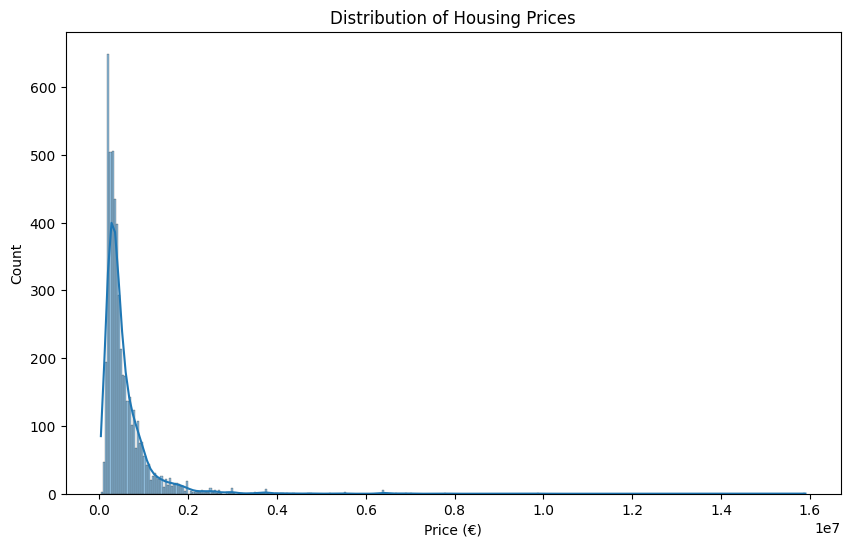

In [6]:
# Explore the target variable (price)
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price (€)')
plt.savefig('price_distribution.png')

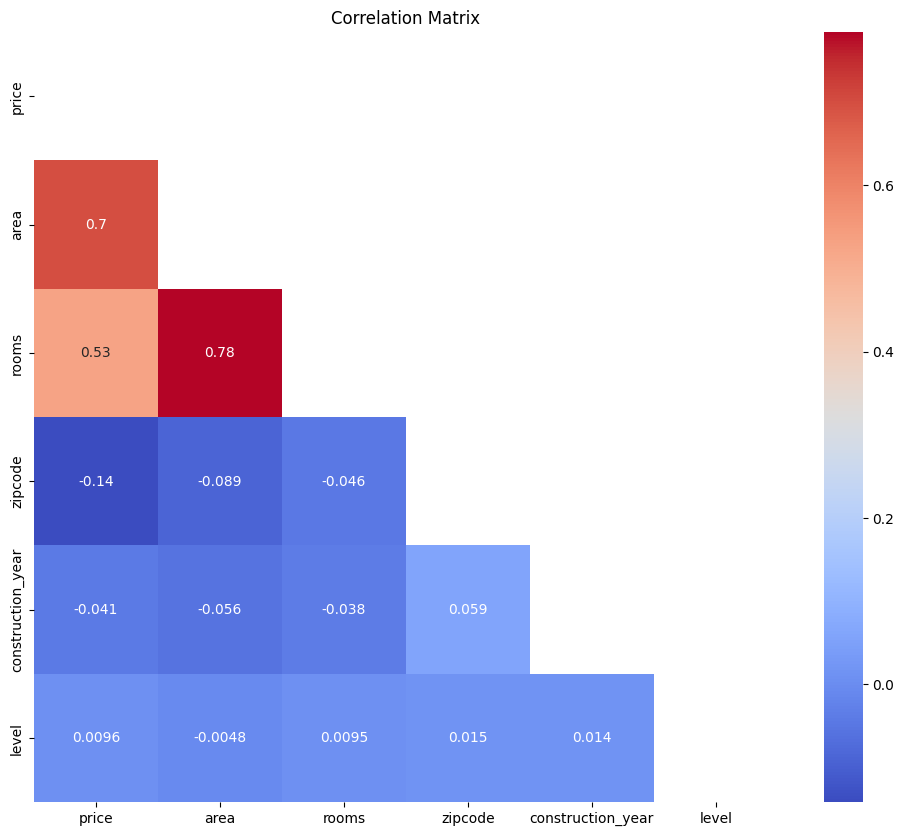

In [7]:
# Explore relationships between features and target
plt.figure(figsize=(12, 10))
correlation = data.select_dtypes(include=[np.number]).corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')

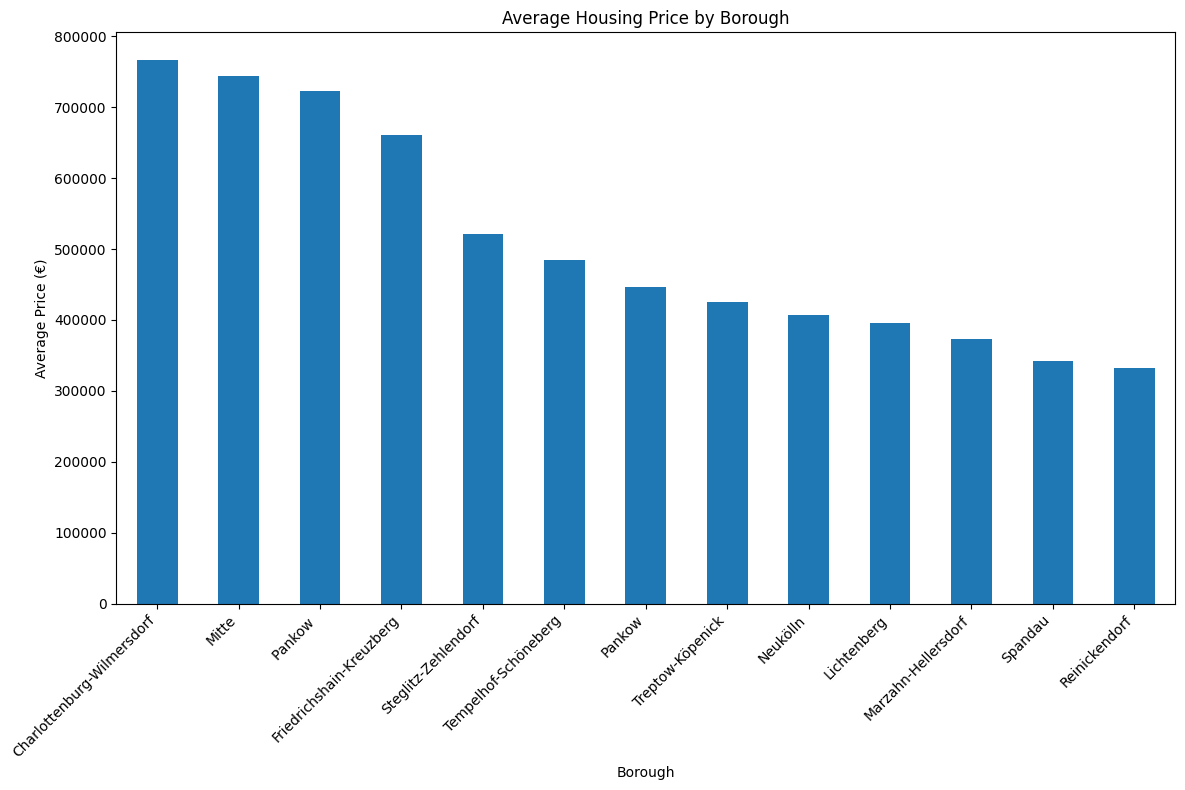

In [8]:
# Explore geographical distribution
plt.figure(figsize=(12, 8))
borough_prices = data.groupby('Borough')['price'].mean().sort_values(ascending=False)
borough_prices.plot(kind='bar')
plt.title('Average Housing Price by Borough')
plt.ylabel('Average Price (€)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('borough_prices.png')

In [ ]:
# Relationship between area and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='price', data=data, alpha=0.6)
plt.title('Price vs. Area')
plt.xlabel('Area (m²)')
plt.ylabel('Price (€)')
plt.savefig('price_vs_area.png')


In [ ]:
# 3. Data Preparation
print("\nPreparing the data...")

# Handle missing values in 'heating' and 'energy' columns
# Replace 'unbekannt' with NaN
data['heating'].replace('unbekannt', np.nan, inplace=True)
data['energy'].replace('unbekannt', np.nan, inplace=True)


In [ ]:
# Function to clean construction_year (some values might be incorrect)
def clean_year(year):
    if pd.isna(year):
        return np.nan
    if year < 1800 or year > 2025:  # Assuming no buildings older than 1800 or newer than 2025
        return np.nan
    return year

data['construction_year'] = data['construction_year'].apply(clean_year)

In [ ]:
# Create feature for building age
current_year = 2023
data['building_age'] = current_year - data['construction_year']

# Feature engineering: price per square meter
data['price_per_sqm'] = data['price'] / data['area']

In [ ]:
# Drop outliers based on price
Q1 = data['price'].quantile(0.01)
Q3 = data['price'].quantile(0.99)
IQR = Q3 - Q1
data_cleaned = data[(data['price'] >= Q1 - 1.5 * IQR) & (data['price'] <= Q3 + 1.5 * IQR)]


In [ ]:
# Split features and target
X = data_cleaned.drop(['price', 'price_per_sqm'], axis=1)
y = data_cleaned['price']

In [ ]:
# Define categorical and numerical features
categorical_features = ['energy', 'heating', 'Borough', 'Neighborhood']
numerical_features = ['area', 'rooms', 'construction_year', 'level', 'building_age']

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [ ]:
# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 4. Modeling
print("\nTraining models...")

# Define different models to try
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'XGBoost': XGBRegressor.XGBRegressor(random_state=42)
}


In [ ]:
# Create directory for model artifacts
if not os.path.exists('model_results'):
    os.makedirs('model_results')


In [ ]:
# Create and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model': pipeline
    }

    print(f"{name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.4f}")

    # Save the model
    joblib.dump(pipeline, f'model_results/{name.replace(" ", "_").lower()}_model.pkl')

    # Visualize actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{name}: Actual vs Predicted Prices')
    plt.savefig(f'model_results/{name.replace(" ", "_").lower()}_predictions.png')


In [ ]:
# 5. Evaluation
print("\nEvaluating models...")

# Find best model based on RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = results[best_model_name]['Model']
best_rmse = results[best_model_name]['RMSE']
best_r2 = results[best_model_name]['R2']

print(f"\nBest Model: {best_model_name}")
print(f"RMSE: {best_rmse:.2f}")
print(f"R2: {best_r2:.4f}")

In [ ]:
# For Random Forest or similar tree-based models, get feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    # Get feature names after one-hot encoding
    preprocessor = best_model.named_steps['preprocessor']
    model = best_model.named_steps['model']

    # Get feature names after preprocessing
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        # Fallback for sklearn < 1.0
        ohe_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
        feature_names = np.concatenate([numerical_features, ohe_features])

    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Plot top 20 features
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.tight_layout()
        plt.savefig('model_results/feature_importance.png')
        print("\nTop 10 Important Features:")
        print(feature_importance.head(10))


In [ ]:
# Save the best model
joblib.dump(best_model, 'best_model.pkl')

# Create a simple prediction function
def predict_price(features_dict):
    """
    Make a price prediction using the best model.

    Args:
        features_dict: Dictionary with feature values

    Returns:
        Predicted price
    """
    # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([features_dict])

    # Make prediction
    prediction = best_model.predict(input_df)[0]
    return prediction

# Example of how to use the prediction function
example_property = {
    'area': 80.0,
    'rooms': 3.0,
    'construction_year': 2000.0,
    'level': 2.0,
    'energy': 'Gas',
    'heating': 'Zentralheizung',
    'Borough': 'Mitte',
    'Neighborhood': 'Mitte',
    'building_age':33
}

print("\nExample Prediction:")
try:
    example_price = predict_price(example_property)
    print(f"Predicted price for example property: €{example_price:.2f}")
except Exception as e:
    print(f"Error making prediction: {e}")

print("\nModel development complete following CRISP-DM methodology.")